## Import Dataset and Libraries

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
data = pd.read_csv("Titanic Dataset.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Visualisation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop('Survived', axis=1), data['Survived'], test_size=0.25, random_state=42)

In [6]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
298,299,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S
884,885,3,"Sutehall, Mr. Henry Jr",male,25.00,0,0,SOTON/OQ 392076,7.0500,NaN,S
247,248,2,"Hamalainen, Mrs. William (Anna)",female,24.00,0,2,250649,14.5000,NaN,S
478,479,3,"Karlsson, Mr. Nils August",male,22.00,0,0,350060,7.5208,NaN,S
305,306,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 298 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  668 non-null    int64  
 1   Pclass       668 non-null    int64  
 2   Name         668 non-null    object 
 3   Sex          668 non-null    object 
 4   Age          536 non-null    float64
 5   SibSp        668 non-null    int64  
 6   Parch        668 non-null    int64  
 7   Ticket       668 non-null    object 
 8   Fare         668 non-null    float64
 9   Cabin        149 non-null    object 
 10  Embarked     666 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 62.6+ KB


In [9]:
object_cols = X_train.select_dtypes('object').columns
object_cols

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

<Axes: >

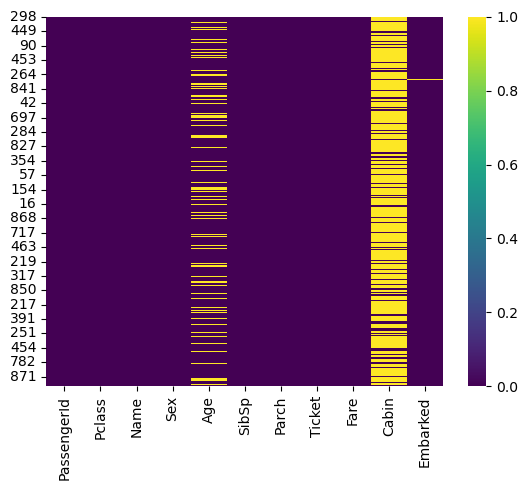

In [10]:
sns.heatmap(X_train.isnull(), cmap='viridis')

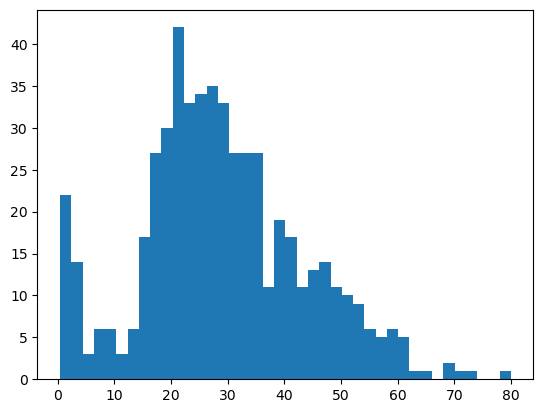

In [11]:
plt.hist('Age', data=X_train, bins=40)
plt.show()

In [12]:
X_train.nunique()

PassengerId    668
Pclass           3
Name           668
Sex              2
Age             82
SibSp            7
Parch            7
Ticket         529
Fare           211
Cabin          113
Embarked         3
dtype: int64

<Axes: xlabel='Embarked', ylabel='Age'>

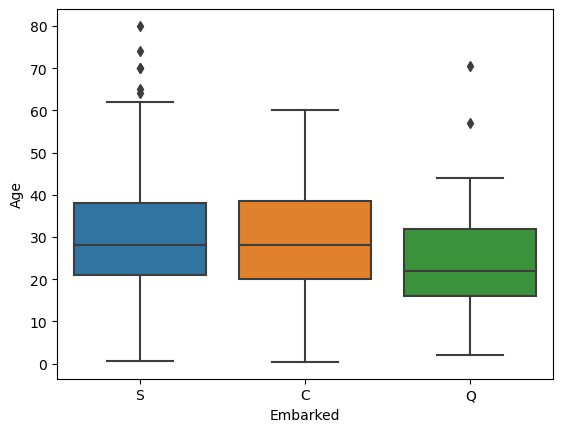

In [13]:
sns.boxplot(data=X_train, y='Age', x='Embarked')

<Axes: xlabel='Pclass', ylabel='Age'>

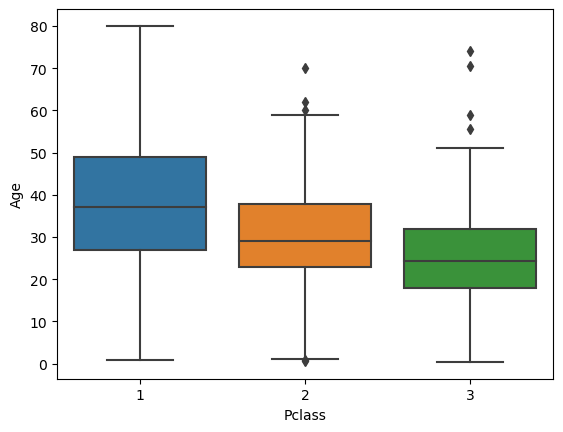

In [14]:
sns.boxplot(data=X_train, y='Age', x='Pclass')

In [15]:
X_train['Embarked'].dropna().mode()

0    S
Name: Embarked, dtype: object

## Model Building

### Creating Pipeline

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

In [18]:
class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        mean_ages = X.groupby('Pclass')['Age'].mean()
        X['Age'] = X['Age'].fillna(X['Pclass'].map(mean_ages))
        return X

In [19]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X['Embarked'].fillna('S', inplace=True)
        OH_cols = pd.DataFrame(encoder.fit_transform(X[['Embarked']]), columns=encoder.get_feature_names_out())
        OH_cols.index = X.index
        X = pd.concat([X, OH_cols], axis=1)
        X.drop('Embarked', axis=1, inplace=True)
        
        OH_cols = pd.DataFrame(encoder.fit_transform(X[['Sex']]), columns=encoder.get_feature_names_out())
        OH_cols.index = X.index
        X = pd.concat([X, OH_cols], axis=1)
        X.drop('Sex', axis=1, inplace=True)
        return X

In [20]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
pipeline = Pipeline(steps = [
    ('coldrop', ColumnDropper()),
    ('imputer', AgeImputer()),
    ('encoder', FeatureEncoder())
])

In [23]:
X_train_new = pipeline.fit_transform(X_train, y_train)
X_test_new = pipeline.transform(X_test)


print(X_train_new.head())
X_test_new.head()

     PassengerId  Pclass        Age  SibSp  Parch      Fare  Embarked_C  \
298          299       1  38.097143      0      0   30.5000         0.0   
884          885       3  25.000000      0      0    7.0500         0.0   
247          248       2  24.000000      0      2   14.5000         0.0   
478          479       3  22.000000      0      0    7.5208         0.0   
305          306       1   0.920000      1      2  151.5500         0.0   

     Embarked_Q  Embarked_S  Sex_female  Sex_male  
298         0.0         1.0         0.0       1.0  
884         0.0         1.0         0.0       1.0  
247         0.0         1.0         1.0       0.0  
478         0.0         1.0         0.0       1.0  
305         0.0         1.0         0.0       1.0  


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
709,710,3,25.759036,1,1,15.2458,1.0,0.0,0.0,0.0,1.0
439,440,2,31.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
840,841,3,20.000000,0,0,7.9250,0.0,0.0,1.0,0.0,1.0
720,721,2,6.000000,0,1,33.0000,0.0,0.0,1.0,1.0,0.0
39,40,3,14.000000,1,0,11.2417,1.0,0.0,0.0,1.0,0.0


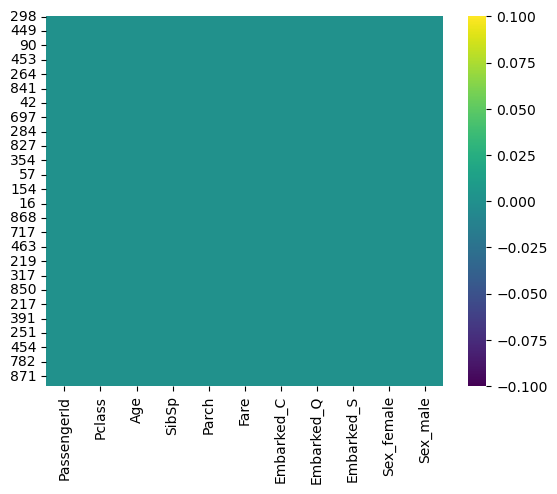

In [24]:
sns.heatmap(X_train_new.isnull(), cmap='viridis')
plt.show()

In [25]:
X_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 298 to 102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  668 non-null    int64  
 1   Pclass       668 non-null    int64  
 2   Age          668 non-null    float64
 3   SibSp        668 non-null    int64  
 4   Parch        668 non-null    int64  
 5   Fare         668 non-null    float64
 6   Embarked_C   668 non-null    float64
 7   Embarked_Q   668 non-null    float64
 8   Embarked_S   668 non-null    float64
 9   Sex_female   668 non-null    float64
 10  Sex_male     668 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 62.6 KB


### Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [27]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators' : [50, 100, 200, 500, 600],
    'max_depth' : [5, 10, 20],
    'min_samples_split' : [2, 5, 10, 15]
}

gridcv = GridSearchCV(estimator=rfc, param_grid=param_grid, verbose=3)

### Hyperparameter Tuning

In [28]:
gridcv.fit(X_train_new, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.784 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.866 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.799 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.797 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_split=2, n_estimators=50;, score=0.827 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_split=2, n_estimators=100;, score=0.784 total time=   0.1s
[CV 2/5] END max_depth=5, min_samples_split=2, n_estimators=100;, score=0.881 total time=   0.1s
[CV 3/5] END max_depth=5, min_samples_split=2, n_estimators=100;, score=0.806 total time=   0.1s
[CV 4/5] END max_depth=5, min_samples_split=2, n_estimators=100;, score=0.782 total time=   0.1s
[CV 5/5] END max_depth=5, min_samples_split=2, n_estimators=100;, scor

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [50, 100, 200, 500, 600]},
             verbose=3)

In [29]:
gridcv.best_params_

{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 500}

### Validating the model

In [30]:
gridcv_pred = gridcv.predict(X_test_new)

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, gridcv_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       134
           1       0.82      0.74      0.78        89

    accuracy                           0.83       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223



In [32]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true=y_test, y_pred=gridcv_pred))

0.8340807174887892


##### Thus we got an accuraccy of about 83%.

## Thank You 